<a href="https://colab.research.google.com/github/nb20593/data-science/blob/main/bank_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib
import itertools

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder

## load data file and create a copy

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/CE888/master/lab3/bank-additional-full.csv",sep =";")
data = df.copy()
data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


# data preprocessing

In [3]:
#Use LabelEncoder to convert the label into numbers.
data[["y"]] = data[["y"]].apply(preprocessing.LabelEncoder().fit_transform)
# drop duration column
data.drop(["duration"],axis=1)
#get dummies for categorical variable
data_dummies = pd.get_dummies(data,columns=["job","marital","education","default","loan","housing","contact","month","day_of_week","poutcome"])
#drop nan rows
data_dummies.dropna()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,loan_no,loan_unknown,loan_yes,housing_no,housing_unknown,housing_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


<function matplotlib.pyplot.show>

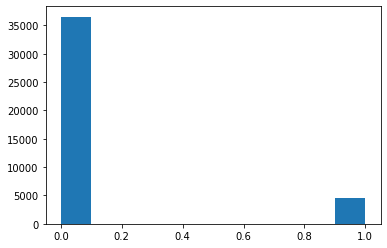

In [4]:
#plot histgrom to check imbalance
plt.hist([data_dummies.y])
plt.show

## model

In [5]:
#define input and outputs
output = data_dummies["y"].values
input = data_dummies.iloc[:,data_dummies.columns !=  "y"]
#train_test data split
x_train,x_test,y_train,y_test = train_test_split(input,output,test_size = 0.2,random_state =50,stratify=output)

In [6]:

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train, y_train)
print("Dummy ACC: %.2f" % acc(y_train, dummy_clf.predict(x_train)))

Dummy ACC: 0.80


In [7]:
clf = RandomForestClassifier(n_estimators=100,max_depth=8)
clf.fit(x_train,y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, scoring=make_scorer(acc))  # cross-validation
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.91 +/- 0.00


In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10,random_state = 50,shuffle=True)
scores = cross_val_score(clf, x_train, y_train, cv=skf, scoring=make_scorer(acc))
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.91 +/- 0.00


In [9]:
from sklearn.model_selection import GridSearchCV
grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]}

gd_sr = GridSearchCV(estimator=clf,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=10,
                     n_jobs=-1)
gd_sr.fit(x_train, y_train)

best_parameters = gd_sr.best_params_
print(best_parameters)

KeyboardInterrupt: ignored

In [10]:
cls = RandomForestClassifier(n_estimators=1000,criterion ='gini',bootstrap= True,max_depth=8)
cls.fit(x_train,y_train)
scores = cross_val_score(cls, x_train, y_train, cv=10, scoring=make_scorer(acc))
print("ACC: %.2f +/- %.2f" % (scores.mean(), scores.std()))

ACC: 0.91 +/- 0.00


In [20]:
from sklearn.metrics import classification_report,f1_score
y_pred = cls.predict(x_test)
c = classification_report(y_test, y_pred)
b = f1_score(y_test, y_pred)
print(c)
print (b)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.74      0.26      0.38       928

    accuracy                           0.91      8238
   macro avg       0.83      0.62      0.67      8238
weighted avg       0.89      0.91      0.89      8238

0.38141025641025644


In [ ]:
features = ["age",
            "job",
            "marital",
            "education",
            "default",
            "housing",
            "loan",
            "contact",
            "month",
            "day_of_week","campaign","pdays","previous","poutcome","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]
feat_importances = pd.Series(cls.feature_importances_, index=x_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()